## Catching the web burglar

Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers. Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from scipy.sparse import hstack  # for stack of sparse matrices
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
# a helper function for writing predicitions to a file
def write_predictions(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels, index=np.arange(1, predicted_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
train_df = pd.read_csv("train_sessions.csv", index_col="session_id")
test_df = pd.read_csv("test_sessions.csv", index_col="session_id")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

We see that time1, time2, ... , time10 are of type "object", so we need to make them of date type.

In [5]:
times = [f"time{i}" for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

train_df = train_df.sort_values(by="time1")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  

In [6]:
train_df.head(10)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0
242171,952,2013-01-12 08:50:22,947.0,2013-01-12 08:50:23,953.0,2013-01-12 08:50:23,946.0,2013-01-12 08:50:23,947.0,2013-01-12 08:50:24,...,2013-01-12 08:50:24,953.0,2013-01-12 08:50:24,955.0,2013-01-12 08:50:24,946.0,2013-01-12 08:50:25,947.0,2013-01-12 08:50:25,0
57157,953,2013-01-12 08:50:25,947.0,2013-01-12 08:50:26,946.0,2013-01-12 08:50:26,953.0,2013-01-12 08:50:26,955.0,2013-01-12 08:50:26,...,2013-01-12 08:50:27,953.0,2013-01-12 08:50:27,946.0,2013-01-12 08:50:27,953.0,2013-01-12 08:50:28,1033.0,2013-01-12 08:50:28,0
240201,946,2013-01-12 08:50:28,947.0,2013-01-12 08:50:28,954.0,2013-01-12 08:50:28,953.0,2013-01-12 08:50:29,946.0,2013-01-12 08:50:29,...,2013-01-12 08:50:29,946.0,2013-01-12 08:50:30,956.0,2013-01-12 08:50:30,957.0,2013-01-12 08:50:31,956.0,2013-01-12 08:50:31,0
210686,946,2013-01-12 08:50:31,956.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:33,955.0,2013-01-12 08:50:33,...,2013-01-12 08:50:33,946.0,2013-01-12 08:50:34,946.0,2013-01-12 08:50:35,946.0,2013-01-12 08:50:36,948.0,2013-01-12 08:50:36,0


**The breakdown of table above**:

Each session represents the sequence of websites that user has visited (session holds up to 1.5 hour). `site` columns contain the number which are the encoded websites urls (`site_dic.pkl` for mapping the code to url). We have the information about sequence, time, and the websites themselves in every observation. `target` represents whether the user is Alice or not (whether the user is okay or he/she is a "burglar").

**Simple approach with `CountVectorizer`:**

At first, we can just ignore the datetimes and work only with sites. We can pass them to `CountVectorizer`.

In [7]:
sites = [f"site{i}" for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv("train_session_text.txt", sep=' ', index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv("test_session_text.txt", sep=' ', index=None, header=None)

In [8]:
!head -5 train_session_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


In [9]:
cv = CountVectorizer()

In [10]:
%%time
with open('train_session_text.txt') as train_file:
    X_train = cv.fit_transform(train_file)
with open('test_session_text.txt') as test_file:
    X_test = cv.transform(test_file)

CPU times: user 2.03 s, sys: 47.4 ms, total: 2.08 s
Wall time: 2.08 s


In [11]:
X_train.shape, X_test.shape

((253561, 41592), (82797, 41592))

In [12]:
y_train = train_df['target'].astype('int')

### Logistic regression

In [13]:
logit = LogisticRegression(random_state=4)

In [14]:
cv_scores = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc')

In [15]:
cv_scores, np.mean(cv_scores)

(array([0.91412172, 0.83253938, 0.87702199, 0.89228333, 0.91380815]),
 0.8859549103521964)

In [16]:
%%time
logit.fit(X_train, y_train)

CPU times: user 16.9 s, sys: 3.32 s, total: 20.2 s
Wall time: 2.57 s


LogisticRegression(random_state=4)

In [17]:
test_predictions_logit = logit.predict_proba(X_test)
test_predictions_logit[:, 1]  # the estimates of positive class

array([2.29620727e-03, 3.44041552e-09, 1.11955344e-08, ...,
       8.71026560e-03, 4.32071676e-04, 1.86125801e-05])

In [18]:
write_predictions(test_predictions_logit[:, 1], 'logit_submission1.txt')  # 0.907 roc_auc on public score, cv 0.885

### Time features

Now we can try to extract some data from the `time` features. We will add `hour` feauture and `day`, `motning`, `evening`, `night` binary features.

In [19]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda x: x.hour)
    morning = ((hour >= 7) & (hour <= 10)).astype('int')
    day = ((hour >= 11) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    
    X = hstack([X_sparse, morning.values.reshape(-1, 1), day.values.reshape(-1, 1), evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1)])
    return X

In [20]:
%%time
X_train_time = add_time_features(train_df.fillna(0), X_train)
X_test_time = add_time_features(test_df.fillna(0), X_test)

CPU times: user 9.7 s, sys: 133 ms, total: 9.84 s
Wall time: 9.84 s


### Logit again

In [21]:
X_train_time.shape

(253561, 41596)

In [22]:
logit2 = LogisticRegression(random_state=4)

In [23]:
cross_val_score(logit2, X_train_time, y_train, cv=5, scoring='roc_auc')

array([0.90936866, 0.88826399, 0.91509921, 0.92791558, 0.93904257])

In [24]:
np.mean([0.90936866, 0.88826399, 0.91509921, 0.92791558, 0.93904257])

0.9159380020000001

In [25]:
%%time
logit2.fit(X_train_time, y_train)

CPU times: user 16 s, sys: 3.33 s, total: 19.4 s
Wall time: 2.52 s


LogisticRegression(random_state=4)

In [26]:
test_predictions_logit2 = logit2.predict_proba(X_test_time)[:, 1]

In [27]:
write_predictions(test_predictions_logit2, "logit2_time_submission2.txt")  # 0.91593 cv score, 0.92651 Kaggle score

### Tuning C hyperparameter to adjust regularization

In [28]:
%%time
Cs = np.logspace(-2, 2, 20)
C_train_scores, C_test_scores = validation_curve(LogisticRegression(random_state=4),
                                                 X_train_time,
                                                 y_train,
                                                 param_name='C',
                                                 param_range=Cs,
                                                 cv=5,
                                                 scoring="roc_auc")

CPU times: user 24min 51s, sys: 4min 25s, total: 29min 17s
Wall time: 3min 50s


In [29]:
def plot_validation_curve(Cs, scores, **kwargs):
    mu, std = scores.mean(1), scores.std(1)
    lines = plt.plot(Cs, mu, **kwargs)
    
    plt.fill_between(
        Cs,
        mu - std,
        mu + std,
        edgecolor="none",
        color=lines[0].get_color(),
        alpha=0.2
    )

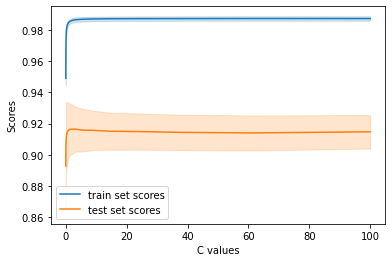

In [30]:
plot_validation_curve(Cs, C_train_scores, label="train set scores")
plot_validation_curve(Cs, C_test_scores, label="test set scores")
plt.xlabel("C values")
plt.ylabel("Scores")
plt.legend();

C values have almost no effect on the model performance starting from C $\geq$ 1.

Let's try finding the best `C` parameter value on `np.logspace(-2, 0, 20)` range.

In [31]:
tscv = TimeSeriesSplit()
split = tscv.split(X_train_time, y_train)

In [32]:
%%time

param_grid = {"C": np.logspace(-2, 0, 20)}

logitcv = GridSearchCV(LogisticRegression(random_state=4),
                       param_grid,
                       scoring='roc_auc',
                       n_jobs=-1,
                       cv=split)
logitcv.fit(X_train_time, y_train)

/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

CPU times: user 19.7 s, sys: 4.48 s, total: 24.2 s
Wall time: 35.6 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x13dcfc350>,
             estimator=LogisticRegression(random_state=4), n_jobs=-1,
             param_grid={'C': array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
       0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
       0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ])},
             scoring='roc_auc')

In [33]:
logitcv.best_params_, logitcv.best_score_

({'C': 0.23357214690901212}, 0.8789461428636315)

In [34]:
logitcv_predictions = logitcv.predict_proba(X_test_time)[:, 1]

In [35]:
write_predictions(logitcv_predictions, "logitcv_submission3.txt")  # 0.87894 time cv, 0.93065 public Kaggle score